# Codificação densa

__Limite de Holevo__: Não é possível extrair mais que $n$ cbits de $n$ qubits.

## Protocolo
Para $|\Phi_+\rangle = (|00\rangle+|11\rangle)/\sqrt{2}$ temos
\begin{align}
& (I\otimes I)|\Phi_+\rangle = |\Phi_+\rangle,\ (Z\otimes I)|\Phi_+\rangle = |\Phi_-\rangle, \\
& (X\otimes I)|\Phi_+\rangle = |\Psi_+\rangle,\ (ZX\otimes I)|\Phi_+\rangle = |\Psi_-\rangle.
\end{align}
i.e., Alice prepara qualquer estado da base de Bell começando em um desses estados.

![](https://drive.google.com/uc?export=view&id=1v_C9Orbq4U7co2nZLK8CYUVmks62H-Ku)


In [ ]:
# instalações
!pip install qiskit
!pip install qiskit_aer
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-ibm-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=865c91a3c3dd7f775523945632de0af218125039bf3899742d032c2952b78e12
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━

In [ ]:
import numpy as np
import math
from qiskit import QuantumCircuit

In [ ]:
def qc_alice_encoding(cb):
    qc = QuantumCircuit(1, name='AE')
    if cb == '00':
        qc.id(0)
    elif cb == '01':
        qc.x(0)
    elif cb == '10':
        qc.z(0)
    elif cb == '11':
        qc.x(0)
        qc.z(0)
    return qc

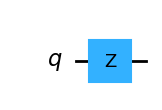

In [ ]:
cb = '10'
qcae = qc_alice_encoding(cb)
qcae.draw('mpl')

In [ ]:
def qc_dense_coding(cb):
    qc = QuantumCircuit(2, name='DC')
    # compartilha o par emaranhado
    qc.h(0)
    qc.cx(0,1)
    qc.barrier()
    # codificação da Alice
    qcae = qc_alice_encoding(cb)
    qc.append(qcae, [0])
    qc.barrier()
    # decodificação, medida na base de Bell, do Bob
    qc.cx(0,1)
    qc.h(0)
    return qc

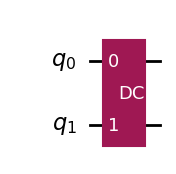

In [ ]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
qcdc = qc_dense_coding('01')
qc.append(qcdc, [0,1])
qc.draw('mpl')

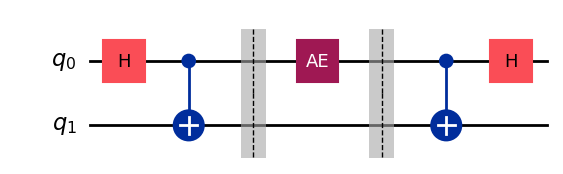

In [ ]:
qc.decompose().draw('mpl')

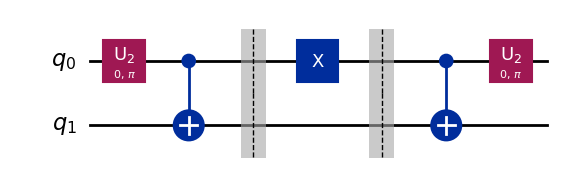

In [ ]:
qc.decompose().decompose().draw('mpl')

### Simulação

In [ ]:
# só há simulador local agora
from qiskit_aer import AerSimulator
backend = AerSimulator()

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

In [ ]:
qc = QuantumCircuit(2,2)
qcdc = qc_dense_coding('01')
qc.append(qcdc, [0,1])
qc.measure([0,1],[0,1])
qc_list = []
qc_list.append(qc.decompose().decompose())
job = sampler.run(qc_list, shots = 2**12 )

In [ ]:
counts_sim = job.result()[0].data.c.get_counts()
counts_sim

{'10': 4096}

### Experimento

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="a49ac98227e162a678cac3401e8abe541465fc21a98fdc4eb5a536d6718ec1cb389c71eab44f577ffc786077102782a9bfbf7f0ad081c46879abd5e8e6920d23")
backend = service.backend(name="ibm_brisbane")

In [ ]:
from qiskit import transpile
qc = QuantumCircuit(2,2)
qcdc = qc_dense_coding('01')
qc.append(qcdc, [0,1])
qc.measure([0,1],[0,1])
qc_list = []
qc_list.append(qc.decompose().decompose())
# pra otimizar implementação (pra evitar erros)
qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True # pra diminuir decoerência
sampler.options.dynamical_decoupling.sequence_type = "XY4"

In [ ]:
job = sampler.run(qc_transpiled_list)
print(job.job_id())

csyz0tk6kcdg008sneyg


In [ ]:
job_id = "csyz0tk6kcdg008sneyg"
job = service.job(job_id)
counts_exp = job.result()[0].data.c.get_counts()
counts_exp # é um dicionário do Python

{'10': 3578, '11': 382, '00': 116, '01': 20}

### Gráfico

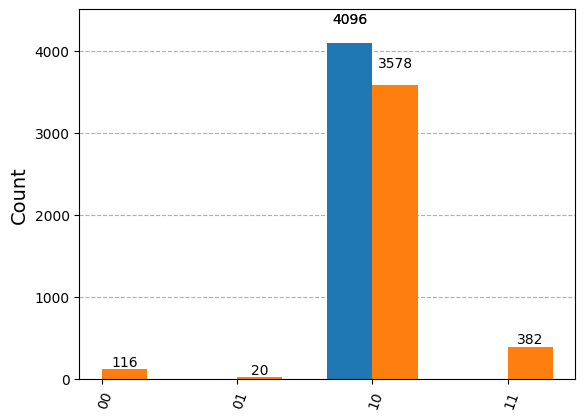

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram([counts_sim,counts_exp])

## Referências

1. C. H. Bennett and S. J. Wiesner, “Communication via one- and two-particle operators on Einstein-Podolsky-Rosen states,” Phys. Rev. Lett., vol. 69, no. 20, pp. 2881-2884, Nov. 1992, doi: 10.1103/PhysRevLett.69.2881.

1. Y. Guo, B.-H. Liu, C.-F. Li, and G.-C. Guo, “Advances in quantum dense coding,” Adv Quantum Tech, vol. 2, no. 5-6, p. 1900011, Jun. 2019, doi: 10.1002/qute.201900011.

1. A. Javadi-Abhari et al., “Quantum computing with Qiskit.” arXiv, May 14, 2024. doi: 10.48550/arXiv.2405.08810.

1. Derek Wang, Coding with Qiskit 1.x, https://youtube.com/playlist?list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi&si=fVV8M_REENx6fcsa